In [36]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from sympy import conjugate
from qiskit_textbook.widgets import plot_bloch_vector_spherical
from torch.autograd import Variable
import torch
from tools import *

# Circuito quantico variacional

    Um circuito quantico variacional é descrito por:

$$f = \langle\psi_0|U^\dagger(\theta)M U(\theta)|\psi_0\rangle
$$
$$ f = \langle\psi_1|M|\psi_1\rangle
$$

In [37]:
# gerando os estados aleatórios
c0 = np.random.rand()**0.5
c1 = (1.0 - c0**2)**0.5
target_state = np.array([[c0],[c1]])
theta = 2*np.arccos(c0)
target_expectedValue = np.cos(theta)

print(target_state)
print(target_expectedValue)

[[0.47336856]
 [0.88086447]]
-0.5518444150461365


# Plotando o estado que queremos preparar

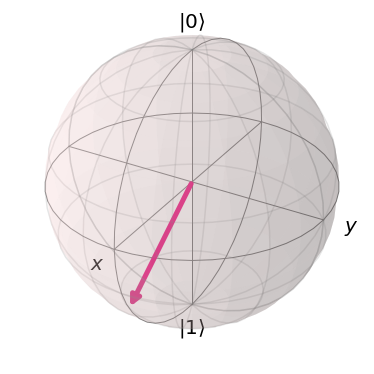

In [38]:
phi = 0
coords = [theta, phi, 1]
plot_bloch_vector_spherical(coords)

# Definindo os parâmetros que serão otimizados

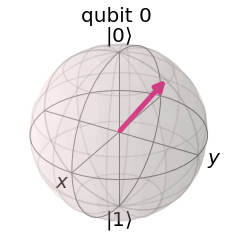

In [39]:
# Qiskit
params = np.random.normal(0, np.pi/2, (2), requires_grad=True)
qc = QuantumCircuit(1)
qc.rx(params[0].item(),0)
qc.ry(params[1].item(),0)
bloch_sphere(qc)

In [40]:
# Pennylane
device = qml.device('qiskit.aer', wires=1, backend='qasm_simulator')
@qml.qnode(device, diff_method='parameter-shift')
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    return qml.expval(qml.PauliZ(0))
qc = circuit(params)


# Treinando os parâmetros

In [ ]:
def loss(params):
    L = abs(target_expectedValue - circuit(params))
    return L
opt = qml.AdamOptimizer(stepsize=0.01)

for i in range(256):
    print(loss(params), circuit(params), target_expectedValue)
    params = opt.step(loss, params)

# Obtendo o estado usando tomografia de estados no circuito


In [45]:
# METHOD 1
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit import Aer
import qiskit
from qiskit import QuantumRegister

qc = QuantumCircuit(1)
qc.rx(params[0].item(), 0)
qc.ry(params[1].item(), 0)

qr = QuantumRegister(1)
qstc = state_tomography_circuits(qc, qr[0])
nshots = 8192
job = qiskit.execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots)
qstf = StateTomographyFitter(job.result(), qstc)
rho = qstf.fit(method='lstsq')
print(rho)


DAGCircuitError: "(qu)bit Qubit(QuantumRegister(1, 'q5394'), 0) not found in OrderedDict([(Qubit(QuantumRegister(1, 'q'), 0), DAGOutNode(wire=Qubit(QuantumRegister(1, 'q'), 0))), (Clbit(ClassicalRegister(1, 'c4'), 0), DAGOutNode(wire=Clbit(ClassicalRegister(1, 'c4'), 0)))])"

In [35]:
# METHOD 2
from qiskit.providers.aer import AerSimulator
from qiskit.providers.fake_provider import FakeParis
from qiskit_experiments.library import StateTomography
from qiskit import BasicAer


qc = QuantumCircuit(1)
qc.rx(params[0].item(),0)
qc.ry(params[1].item(),0)

qstexp1 = StateTomography(qc)
#backend = AerSimulator.from_backend(FakeParis())
backend = BasicAer.get_backend('qasm_simulator')
qstdata1 = qstexp1.run(backend, seed_simulation=100).block_for_results()
state_result = qstdata1.analysis_results("state")

print(type(state_result.value))
print(state_result.value)

<class 'qiskit.quantum_info.states.densitymatrix.DensityMatrix'>
DensityMatrix([[ 0.11230469+0.j        , -0.01757812+0.31152344j],
               [-0.01757812-0.31152344j,  0.88769531+0.j        ]],
              dims=(2,))


### Fidelidade

* Estados puros $ F(\rho,\sigma) = Tr[\rho\sigma\rho]^{1/2} = Tr[|\phi\rangle\langle\phi|\psi\rangle\langle\psi|\phi\rangle\langle\phi|]^{1/2} = |\langle\psi|\phi\rangle|$.

* Estados que são diagonais numa mesma base (comutativos) $ F(\rho,\sigma) = \sum_i\sqrt{p_iq_i} $

In [13]:
def fidelity(rho1, rho2):
    result = abs(inner_product(rho1, rho2))
    return result

In [ ]:
print(fidelity(target_state, target_state))

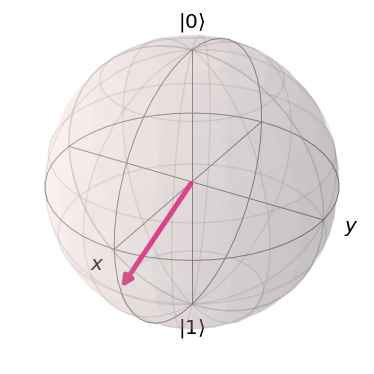

In [6]:
from qiskit_textbook.widgets import plot_bloch_vector_spherical
theta = 2*np.arccos(c0)
target_expectedValue = np.cos(theta)
phi = 0
coords = [theta, phi, 1]

plot_bloch_vector_spherical(coords)

In [7]:
def vqa_prep(target_state, device):
    device = qml.device('qiskit.aer', wires=1, backend='qasm_simulator')
    params = np.random.normal(0, np.pi/2, (2), requires_grad=True)
    @qml.qnode(device, diff_method='parameter-shift')
    def circuit(params):
        qml.RX(params[0], wires=0)
        qml.RY(params[1], wires=0)

        return qml.expval(qml.PauliZ(0))

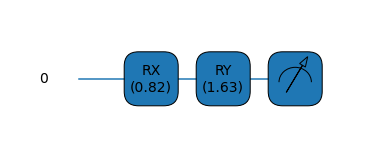

In [8]:
device = qml.device('qiskit.aer', wires=1, backend='qasm_simulator')

params = np.random.normal(0, np.pi/2, (2), requires_grad=True)

@qml.qnode(device, diff_method='parameter-shift')

def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)

    return qml.expval(qml.PauliZ(0))

fig, ax = qml.draw_mpl(circuit, decimals=2)(params)
plt.show()

In [43]:
pauli_observables = [
    qml.PauliX(0),
    qml.PauliY(0),
    qml.PauliZ(0)
]

Paulis = Variable(torch.zeros([3, 2, 2], dtype=torch.complex128), requires_grad=False)
Paulis[0] = torch.tensor([[0, 1], [1, 0]])
Paulis[1] = torch.tensor([[0, -1j], [1j, 0]])
Paulis[2] = torch.tensor([[1, 0], [0, -1]])

In [42]:
purity = 0.5 + 0.5*np.random.rand()
target_vector = np.random.normal(0, 1, 3)
target_vector = target_vector/(np.sum(target_vector**2))
target_vector = target_vector*(2*purity - 1 )**0.5
target_vector = Variable(torch.Tensor(target_vector))
print(target_vector)
print(purity)

tensor([-0.0230, -0.0784, -0.4612])
0.7594157662604152


In [17]:
def cost(params):
    L = 0
    for k in range(3):
        L+= torch.abs(circuit(params, Paulis[k]) - target_vector[k])
    return L

opt = torch.optim.Adam([params], lr=0.1)
best_loss = 1*cost(params)
best_params = 1*params


NameError: name 'torch' is not defined

In [44]:
X_exp = circuit(params, Paulis[0]).item()
Y_exp = circuit(params, Paulis[1]).item()
Z_exp = circuit(params, Paulis[2]).item()
print(X_exp, Y_exp, Z_exp)

TypeError: circuit() takes 1 positional argument but 2 were given

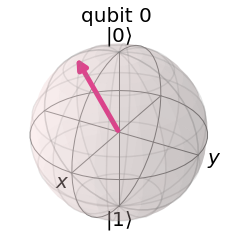

In [51]:
qc = QuantumCircuit(1,1)
qc.rx(params[0].item(),0)
qc.ry(params[1].item(),0)
bloch_sphere(qc)

In [54]:
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.providers.aer import QasmSimulator
import qiskit

qstc = state_tomography_circuits(qc, qc[0])
nshots = 8192
job = qiskit.execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots)
qstf = StateTomographyFitter(job.result(), qstc)
rho = qstf.fit(method='lstsq')
print(rho)

TypeError: unhashable type: 'CircuitInstruction'

In [ ]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(1)
qc.rx(params[0].item(),0)
qc.ry(params[1].item(),0)

from qiskit.visualization import visualize_transition
visualize_transition(qc)